# Player price and skills correlation: position-specific approach


#### Disclaimer: so far I haven't work with data visualization, so I tried to find some non-trivial correlation and visualize it to begin with. Hope this notebook will come in handy =)

### Get started with necessary libs and data

In [111]:
%matplotlib inline
from __future__ import print_function
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [157]:
price = pd.read_csv('player_price.csv', sep = ",")
stats = pd.read_csv('player_stats.csv', sep = ",")
print(price.shape)
print(stats.shape)

(967302, 5)
(4600, 78)


In [9]:
price['timestamp'] = pd.to_datetime(price['timestamp'], unit='ms')

In [10]:
price.head()

,timestamp,ps_price,xbox_price,player_id,player_name
0,2016-09-23,0,0,1,Pelé
1,2016-09-24,0,10000000,1,Pelé
2,2016-09-25,0,0,1,Pelé
3,2016-09-26,0,0,1,Pelé
4,2016-09-27,0,10000000,1,Pelé


In [11]:
stats.head()

,acceleration,aggression,agility,balance,ball,composure,crossing,curve,defending,diving,...,origin,revision,skills,weak_foot,weight,colour,front_scores,overall_score,position,rareness
0,95,55,94,94,94,0,87,81,53,0,...,N\A,Legend,5,4,70,gold,"{'PHY': '73', 'DEF': '53', 'DRI': '94', 'PAS':...",95,CF,rare
1,83,63,80,66,89,0,64,76,94,0,...,N\A,Legend,3,3,75,gold,"{'PHY': '81', 'DEF': '94', 'DRI': '79', 'PAS':...",93,CB,rare
2,87,66,65,69,72,0,83,31,95,0,...,N\A,Legend,2,4,85,gold,"{'PHY': '80', 'DEF': '95', 'DRI': '67', 'PAS':...",92,LB,rare
3,77,79,75,84,89,0,58,56,94,0,...,N\A,Legend,2,3,70,gold,"{'PHY': '82', 'DEF': '94', 'DRI': '70', 'PAS':...",92,CB,rare
4,88,93,74,79,87,0,81,72,88,0,...,N\A,Legend,3,4,71,gold,"{'PHY': '82', 'DEF': '88', 'DRI': '77', 'PAS':...",91,CDM,rare


## Create new variables for the stats dataframe

### Mean player price for the whole observation period

In [162]:
means = []
for player in price.player_id.unique():
    df = price[price.player_id == player]
    mean_price = np.mean(df.xbox_price)
    means.append(mean_price)
stats['price'] = pd.Series(means)

### Standard deviation of price changes:
#### #Measures how volatile (unstable and prone to surges) the price is

In [186]:
stds = []
for player in price.player_id.unique():
    df = price[price.player_id == player]
    prices = df.xbox_price
    price_diffs = prices.diff(periods=1).dropna()
    stds.append(np.std(price_diffs))
stats['volatility'] = pd.Series(stds)

### Price change score:
#### #Measures how the price was changing during the observation period (positive value for the cards that mostly grew in price, negative for the cards with falling price, close to zero for stable cards and those with constant growths and falls)

In [164]:
changes = []
for player in price.player_id.unique():
    df = price[price.player_id == player]
    prices = df.xbox_price
    price_diffs = prices.diff(periods=1).dropna()
    try:
        changes.append(10000 * np.mean(price_diffs) / np.mean(prices))
    except ZeroDivisionError:
        changes.append(0)
stats['change'] = pd.Series(changes)

## The main assumption to check is that apart from general player score, position-specific parameters also tend to correlate with the player price and its change and volatility.

### As expected, there is a correlation between overall score and the price of the player

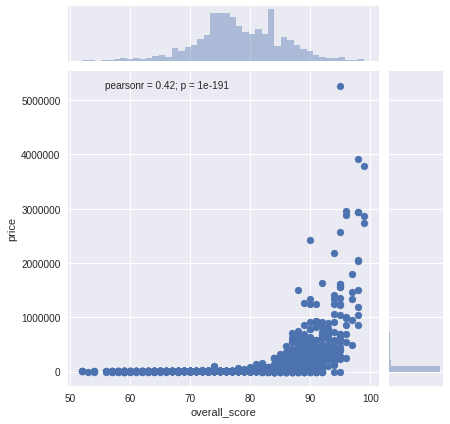

In [166]:
sns.jointplot("overall_score", "price", data=stats)

### Create new dataframes by player positions

In [191]:
# Leave relevant parameters only
stats = stats[[u'acceleration', u'aggression', u'agility', u'balance', u'ball',
       u'composure', u'crossing', u'curve', u'defending', u'diving',
       u'dribbling', u'finishing', u'fk', u'handling', u'heading',
       u'interceptions', u'jumping', u'kicking', u'long', u'marking', u'pace',
       u'passing', u'penalties', u'physicality', u'positioning',
       u'raits', u'reactions', u'reflexes', u'shooting', u'short', u'shot',
       u'sliding', u'specialities', u'speed', u'sprint', u'stamina',
       u'standing', u'strength', u'vision', u'volleys', u'age', u'foot', u'height', u'weak_foot',
       u'weight', u'position', u'price', u'volatility', u'change']]

In [192]:
"""
    Create dataframes accoring to the player positions
""" 

# wing defending positions
stat_wdef = stats[(stats['position'] == 'LWB') \
              | (stats['position'] == 'RWB') \
              | (stats['position'] == 'LB') \
              | (stats['position'] == 'RB') ]
# central defending position
stat_cdef = stats[(stats['position'] == 'CB')]
# central defending midfielder
stat_cdm = stats[(stats['position'] == 'CDM')]
# central attacking midfielder
stat_cam = stats[(stats['position'] == 'CAM')]
# attacking positions
stat_attack = stats[(stats['position'] == 'ST') \
                       | (stats['position'] == 'CF') \
                       | (stats['position'] == 'LF') \
                       | (stats['position'] == 'RF') \
                       | (stats['position'] == 'LW') \
                       | (stats['position'] == 'RW')]

# middle positions
stat_middle = stats[(stats['position'] == 'LM') \
                    | (stats['position'] == 'RM') \
                    | (stats['position'] == 'CM')]
# goalkeepers
stat_gk = stats[(stats['position'] == 'GK')]

In [209]:
def plot_corr(df, price_criterion):
    """
        Plot one of the price variables and relevant skills
        aggregation to check the correlation.
    """
    top_stats = []
    # get stats that are generally high for all the players within position
    for stat in df.drop(['price', 'foot', 'position', 'height', 'weight', 'raits', 'specialities'], axis = 1):
        if df[stat].mean() > 75 and df[stat].mean() < 100:
            top_stats.append(stat)
    # display the stats
    print('Key stats:')
    for stat in top_stats:
        print(stat)
        
    #set the summary score for the top stats
    factor = []
    for player in df.iterrows():
        stat_sum = 0
        for stat in top_stats:
            stat_sum += player[1][stat]
        factor.append(stat_sum / len(top_stats))
    df['factor'] = factor
    """
       Show the correlation for players with decent skills, excluding 
       extra expensive ones
    """
    df = df[(df['factor'] > 70) & (df['price'] < 100000)]
    sns.jointplot("factor", price_criterion, data=df, size = 5)

### Let's plot the mean price first

Key stats:
diving
handling
kicking
positioning
factor


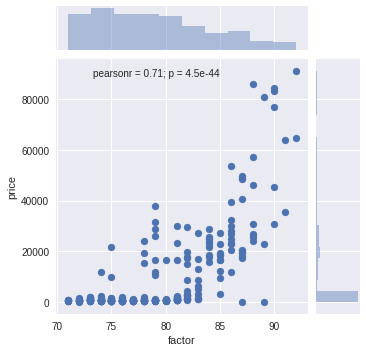

In [210]:
plot_corr(stat_gk, 'price')

Key stats:
aggression
defending
heading
interceptions
jumping
marking
physicality
sliding
standing
strength
factor


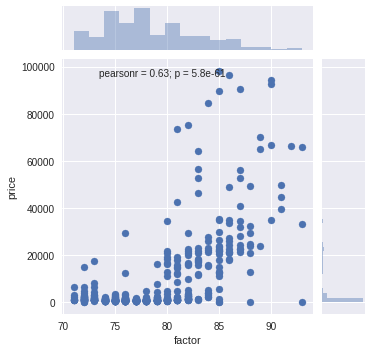

In [197]:
plot_corr(stat_cdef, 'price')

Key stats:
acceleration
pace
sliding
sprint
stamina
standing


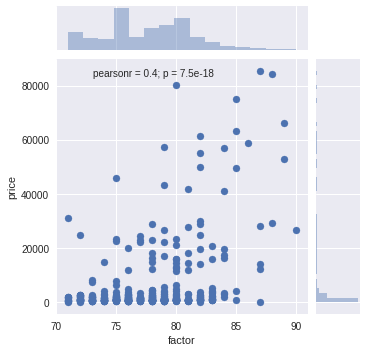

In [198]:
plot_corr(stat_wdef, 'price')

Key stats:
aggression
ball
interceptions
long
physicality
reactions
short
stamina
standing
strength
factor


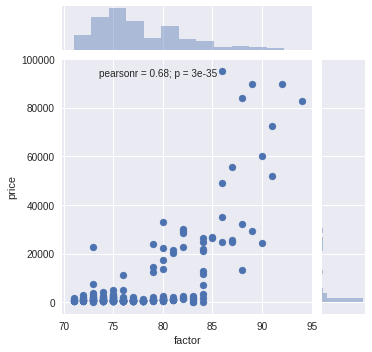

In [201]:
plot_corr(stat_cdm, 'price')

Key stats:
acceleration
agility
balance
ball
curve
dribbling
passing
positioning
short
shot
vision
factor


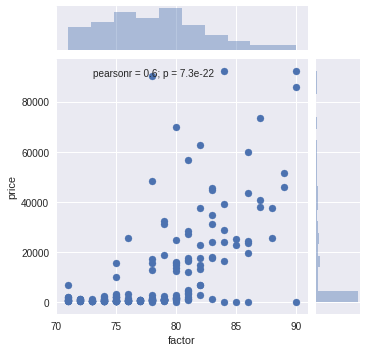

In [202]:
plot_corr(stat_cam, 'price')

Key stats:
acceleration
agility
balance
ball
dribbling
pace
passing
reactions
short
shot
sprint
stamina
vision


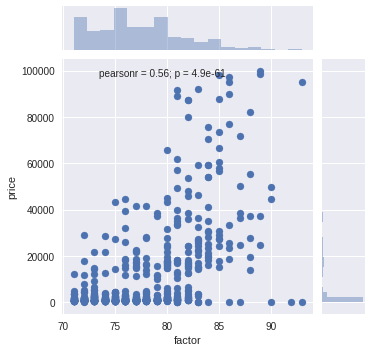

In [205]:
plot_corr(stat_middle, 'price')

Key stats:
acceleration
agility
ball
dribbling
finishing
pace
positioning
reactions
shooting
shot
sprint
stamina
volleys
factor


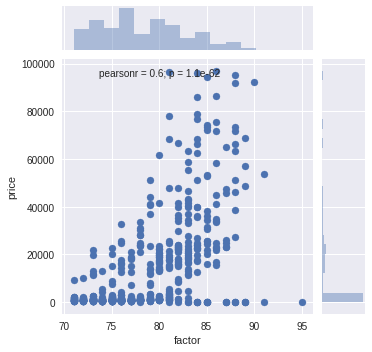

In [206]:
plot_corr(stat_attack, 'price')

### Plot the volatility correlation

Key stats:
diving
handling
kicking
positioning
factor


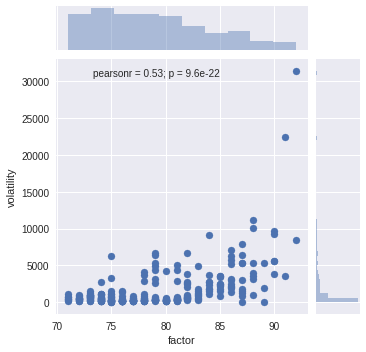

In [211]:
plot_corr(stat_gk, 'volatility')

Key stats:
aggression
defending
heading
interceptions
jumping
marking
physicality
sliding
standing
strength
factor


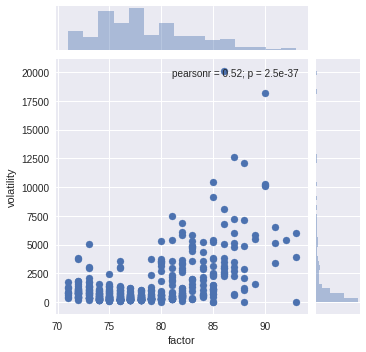

In [213]:
plot_corr(stat_cdef, 'volatility')

Key stats:
acceleration
pace
sliding
sprint
stamina
standing
factor


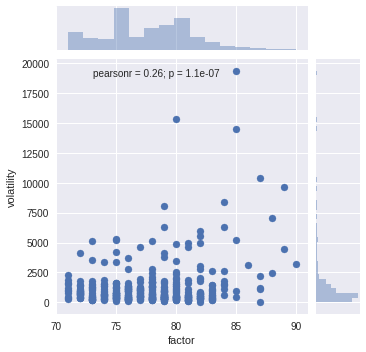

In [214]:
plot_corr(stat_wdef, 'volatility')

Key stats:
aggression
ball
interceptions
long
physicality
reactions
short
stamina
standing
strength
factor


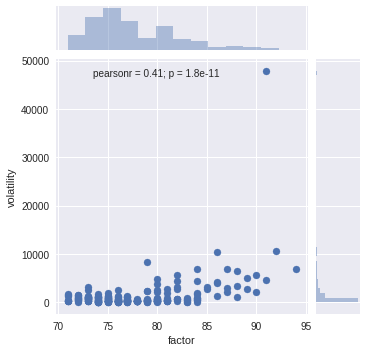

In [215]:
plot_corr(stat_cdm, 'volatility')

Key stats:
acceleration
agility
balance
ball
curve
dribbling
passing
positioning
short
shot
vision
factor


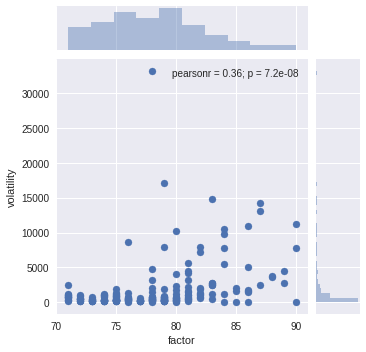

In [217]:
plot_corr(stat_cam, 'volatility')

Key stats:
acceleration
agility
balance
ball
dribbling
pace
passing
reactions
short
shot
sprint
stamina
vision
factor


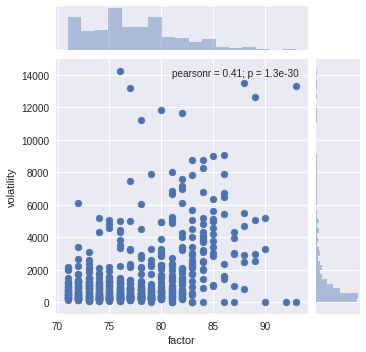

In [218]:
plot_corr(stat_middle, 'volatility')

Key stats:
acceleration
agility
ball
dribbling
finishing
pace
positioning
reactions
shooting
shot
sprint
stamina
volleys
factor


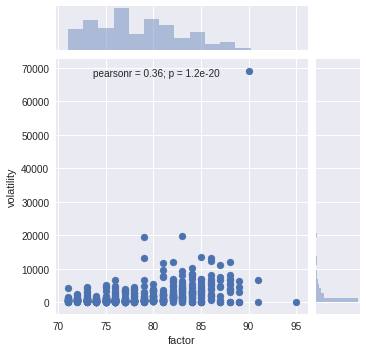

In [219]:
plot_corr(stat_attack, 'volatility')

## Finally, lets see how overall price change correlates with skills

Key stats:
diving
handling
kicking
positioning
factor


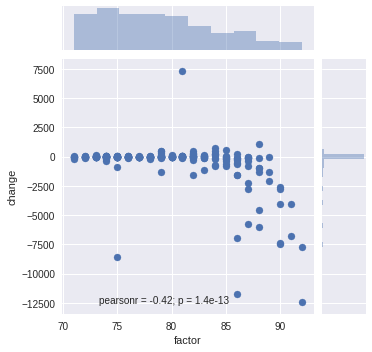

In [220]:
plot_corr(stat_gk, 'change')

Key stats:
aggression
defending
heading
interceptions
jumping
marking
physicality
sliding
standing
strength
factor


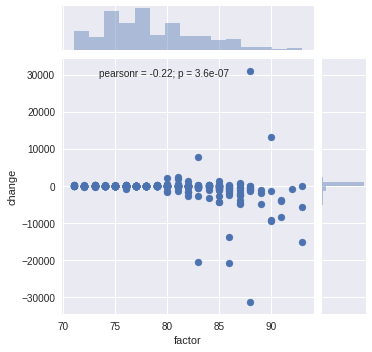

In [221]:
plot_corr(stat_cdef, 'change')

Key stats:
acceleration
pace
sliding
sprint
stamina
standing
factor


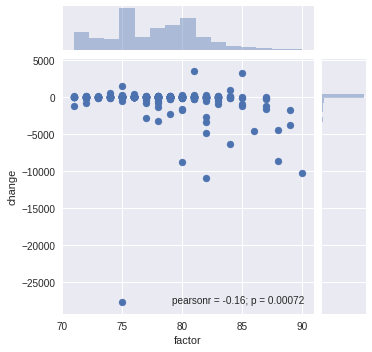

In [222]:
plot_corr(stat_wdef, 'change')

Key stats:
aggression
ball
interceptions
long
physicality
reactions
short
stamina
standing
strength
factor


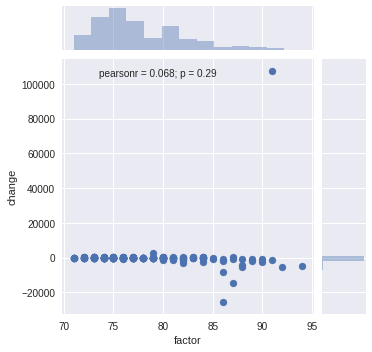

In [223]:
plot_corr(stat_cdm, 'change')

Key stats:
acceleration
agility
balance
ball
curve
dribbling
passing
positioning
short
shot
vision
factor


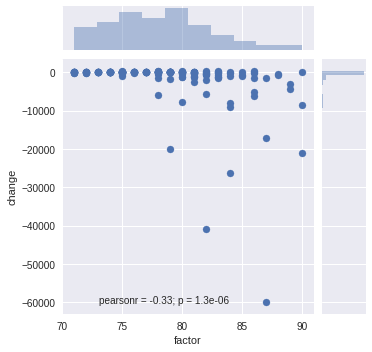

In [224]:
plot_corr(stat_cam, 'change')

Key stats:
acceleration
agility
balance
ball
dribbling
pace
passing
reactions
short
shot
sprint
stamina
vision
factor


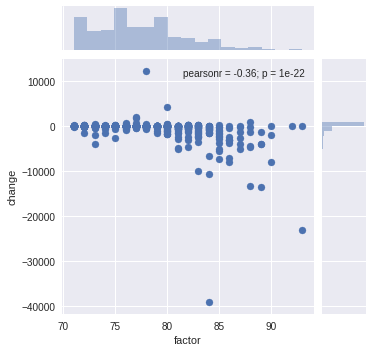

In [225]:
plot_corr(stat_middle, 'change')

Key stats:
acceleration
agility
ball
dribbling
finishing
pace
positioning
reactions
shooting
shot
sprint
stamina
volleys
factor


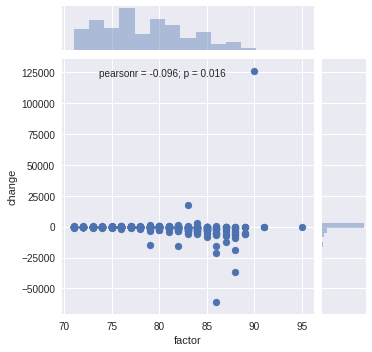

In [226]:
plot_corr(stat_attack, 'change')

# Conclusions
### 1.1 Mean player price and position-specific score aggregation show high correlation for the players with decent skills.
### 1.2 Price volatility is also correlated with position scores: higher score - less stable price.
### 1.3 General price change shows almost no correlation with skills with an exception for goalkeepers: higher skilled players tend to lose their card value faster.

### 2. As position-specific parameters have proven their relevance, they can be used as criteria for recruiting and dream-team constructors.
